# Specific Diagnosis

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# !pip install scikit-optimize # = skopt
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import plot_confusion_matrix


# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')
import helpers


RANDOM = 43
SCORER = make_scorer(f1_score, average='macro')
def SCORE(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def get_feature_names(pipeline_object):
    num_feat = pipeline_object[0].transformers_[0][2]
    one_hot_feat = pipeline_object[0].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
    return list(num_feat) + list(one_hot_feat)

def plot_featureimportance(pipeline_object):
    a = pd.DataFrame()
    a['value'] = pipeline_object[1].feature_importances_
    a['feature'] = get_feature_names(pipeline_object)
    a = a.sort_values(by='value', ascending=False)
    plt.figure(figsize=(10,7))
    g = sns.barplot(y=a.feature, x=a.value*100, data= a, color = 'steelblue')
    helpers.plot_wrapper(g, 'Feature Importances', None, 'Percentage', 'Feature Name')

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [2]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat', 'loc'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True,
                             min_other= 20) 
df.head()

,gender,specific_diagnosis,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,idiopathic_anterior,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,pars planitis,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,vkh,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,idiopathic_anterior,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,idiopathic_anterior,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


#### Updating specific diagnosis grouping:

In [3]:
# drop nonneoplastic masquerade and neoplastic masquerade
df.replace(['idiopathic_anterior','idiopathic_posterior','idiopathic_panuveitis'], 'idiopathic', inplace=True)
df.replace(['presumed_sarcoidosis','bx_proven_sarcoidosis'], 'sarcoidosis', inplace=True)

### Split into uveitis and not_uveitis data

In [4]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

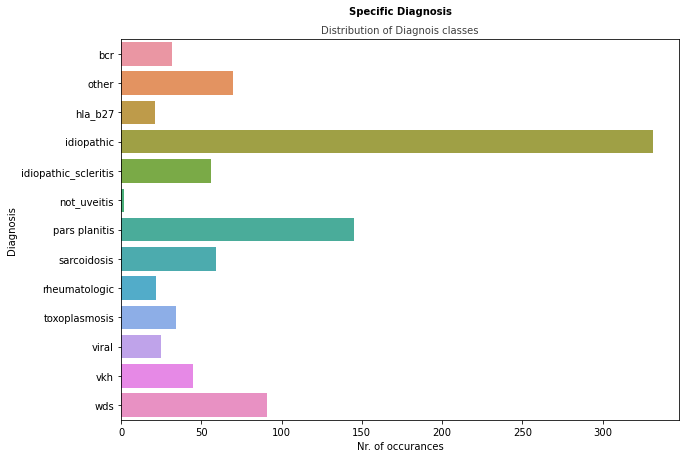

In [5]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['specific_diagnosis']) # drop records with missing location data (3)

plt.figure(figsize=(10,7))
g = sns.countplot(y=df_uv_pos_clean['specific_diagnosis'])
helpers.plot_wrapper(g, 'Specific Diagnosis','Distribution of Diagnois classes','Nr. of occurances','Diagnosis')

**Discussion** Idiopathic is extremly over represented. We can try to minimize this effect by downsampling the data. In other words, we randomly remove a large portion of records with the label 'idiopatic' 

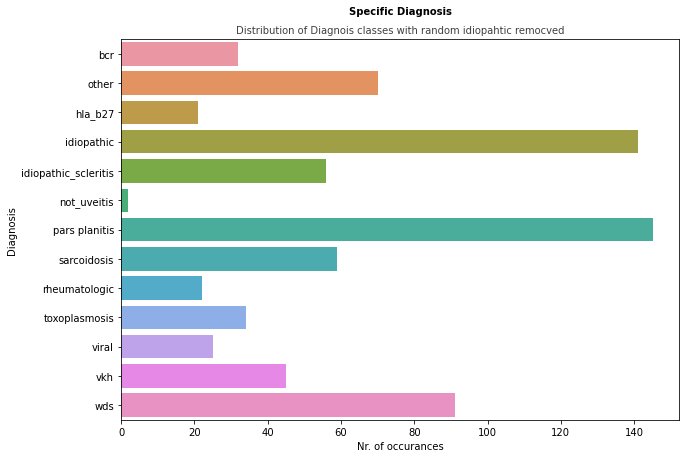

In [6]:
# downsample idiopathic
index = df_uv_pos_clean[df_uv_pos_clean.specific_diagnosis == 'idiopathic'].sample(n=190).index
df_uv_pos_clean.drop(index=index, inplace=True)
plt.figure(figsize=(10,7))
g = sns.countplot(y=df_uv_pos_clean['specific_diagnosis'])
helpers.plot_wrapper(g, 'Specific Diagnosis','Distribution of Diagnois classes with random idiopahtic remocved','Nr. of occurances','Diagnosis')

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [7]:
# train_test_split
df_uv_pos_clean = df_uv_pos_clean[df_uv_pos_clean.specific_diagnosis != 'not_uveitis']
df_uv_pos_clean.specific_diagnosis.cat.remove_unused_categories()
X = df_uv_pos_clean.drop(columns=['specific_diagnosis','uveitis','gender'])
y = df_uv_pos_clean['specific_diagnosis']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['specific_diagnosis','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['specific_diagnosis','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['specific_diagnosis']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['specific_diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

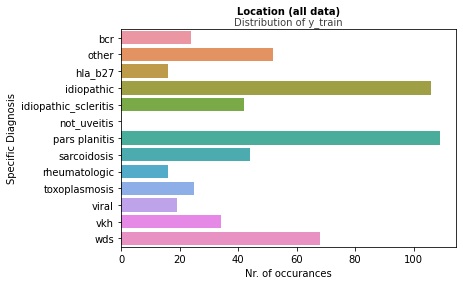

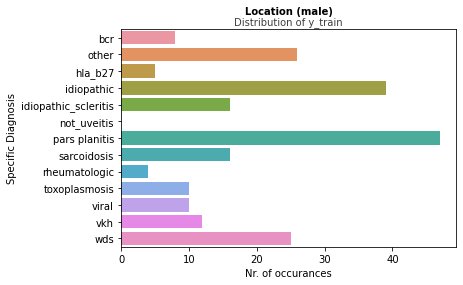

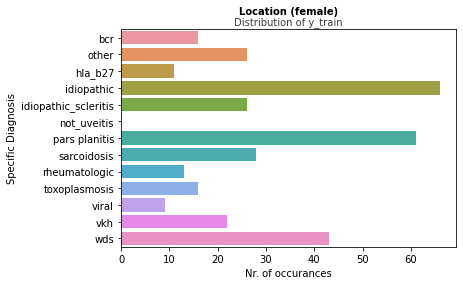

In [8]:
g = sns.countplot(y=y_train)
helpers.plot_wrapper(g, 'Location (all data)','Distribution of y_train','Nr. of occurances','Specific Diagnosis')
g = sns.countplot(y=y_train_m)
helpers.plot_wrapper(g, 'Location (male)','Distribution of y_train','Nr. of occurances','Specific Diagnosis')
g = sns.countplot(y=y_train_f)
helpers.plot_wrapper(g, 'Location (female)','Distribution of y_train','Nr. of occurances','Specific Diagnosis')

#### Imputation and Encoding

In [9]:
# filter for numeric and categorical features
numerics = ['Int64','Float64']
category = ['category','bool','object']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [10]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.06405420026943141
Class probabilites: [0.04324324 0.02882883 0.19099099 0.07567568 0.09369369 0.1963964
 0.02882883 0.07927928 0.04504505 0.03423423 0.06126126 0.12252252]


### Male positive data

In [11]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.0866013071895425
Class probabilites: [0.03669725 0.02293578 0.17889908 0.0733945  0.11926606 0.21559633
 0.01834862 0.0733945  0.04587156 0.04587156 0.05504587 0.1146789 ]


### Female positive data

In [12]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.07542506105006105
Class probabilites: [0.04747774 0.03264095 0.1958457  0.07715134 0.07715134 0.1810089
 0.03857567 0.08308605 0.04747774 0.02670623 0.0652819  0.12759644]


## Decision Tree

### Complete positive data

Score: 0.1798551220130753
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 14, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
                      precision    recall  f1-score   support

                 bcr       0.29      0.25      0.27         8
             hla_b27       0.00      0.00      0.00         5
          idiopathic       0.29      0.29      0.29        35
idiopathic_scleritis       0.14      0.21      0.17        14
               other       0.08      0.11      0.09        18
       pars planitis       0.08      0.06      0.06        36
       rheumatologic       0.50      0.33      0.40         6
         sarcoidosis       0.36      0.33      0.34        15
       toxoplasmosis       0.00      0.00      0.00         9
               viral       0.17      0.17      0.17         6
                 vkh       0.18      0.18      0.18        11
                 wds       0.21      0.17 

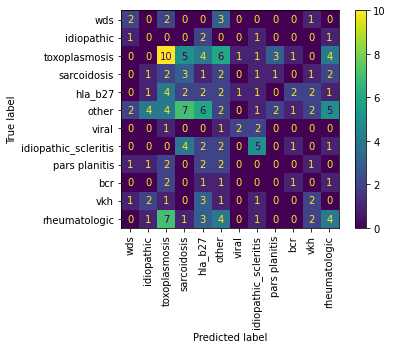

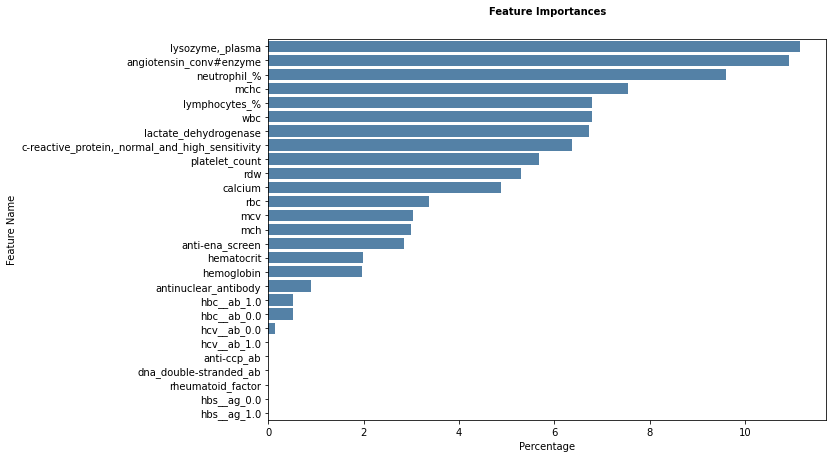

In [13]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced'] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.041666666666666664
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 12, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'best'}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         3
             hla_b27       0.00      0.00      0.00         2
          idiopathic       0.00      0.00      0.00        14
idiopathic_scleritis       0.07      0.20      0.10         5
               other       0.17      0.11      0.13         9
       pars planitis       0.00      0.00      0.00        16
       rheumatologic       0.00      0.00      0.00         1
         sarcoidosis       0.20      0.40      0.27         5
       toxoplasmosis       0.00      0.00      0.00         3
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         4
                 wds       0.00      0.00 

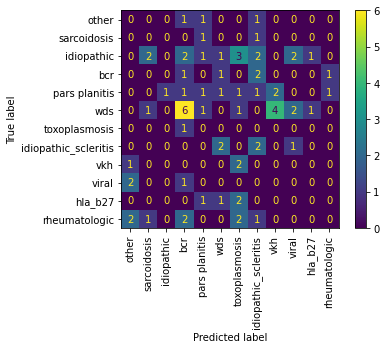

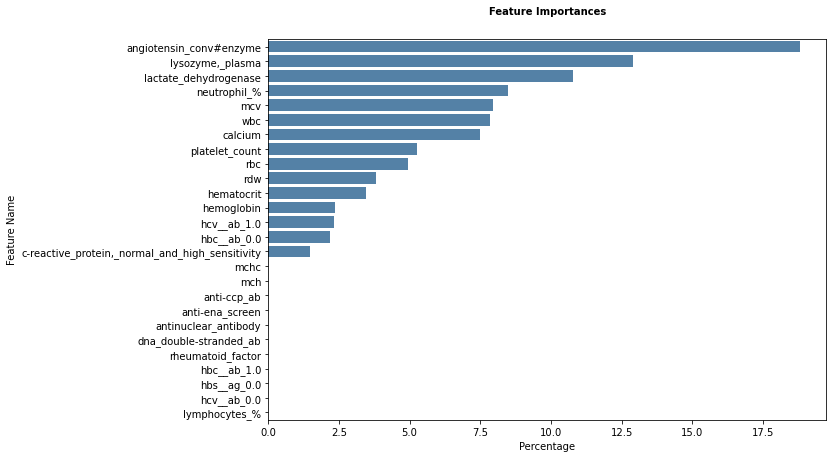

In [14]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.18649828485354802
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 12, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
                      precision    recall  f1-score   support

                 bcr       0.11      0.20      0.14         5
             hla_b27       0.00      0.00      0.00         3
          idiopathic       0.21      0.14      0.17        22
idiopathic_scleritis       0.00      0.00      0.00         9
               other       0.14      0.11      0.12         9
       pars planitis       0.27      0.19      0.22        21
       rheumatologic       0.50      0.50      0.50         4
         sarcoidosis       0.30      0.30      0.30        10
       toxoplasmosis       0.14      0.20      0.17         5
               viral       0.17      0.33      0.22         3
                 vkh       0.17      0.29      0.21         7
                 wds       0.17      0.20 

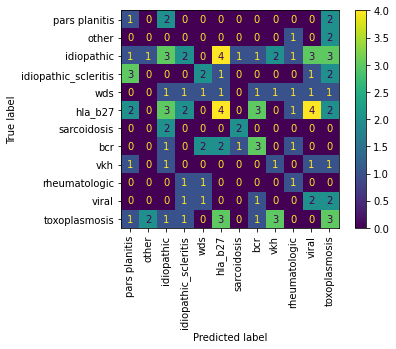

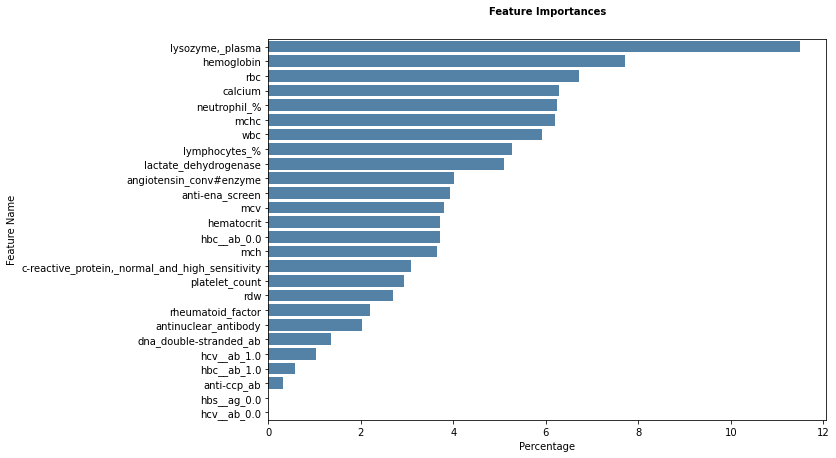

In [15]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.13269502546567363
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 100, 'tree__oob_score': True}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         8
             hla_b27       0.00      0.00      0.00         5
          idiopathic       0.17      0.29      0.22        35
idiopathic_scleritis       0.33      0.07      0.12        14
               other       0.00      0.00      0.00        18
       pars planitis       0.21      0.44      0.28        36
       rheumatologic       0.50      0.17      0.25         6
         sarcoidosis       0.45      0.33      0.38        15
       toxoplasmosis       0.00      0.00      0.00         9
               viral       0.00      0.00      0.00         6
                 vkh       0.50      0.09      0.15        11
                 wds       0.21      0.17      0.19        23

            accuracy                           0.20       186
   

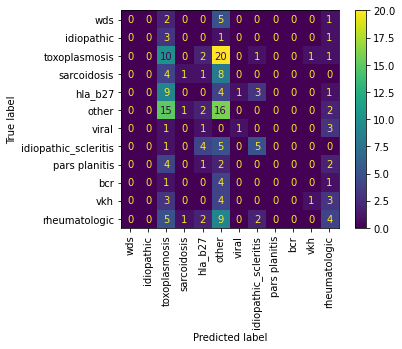

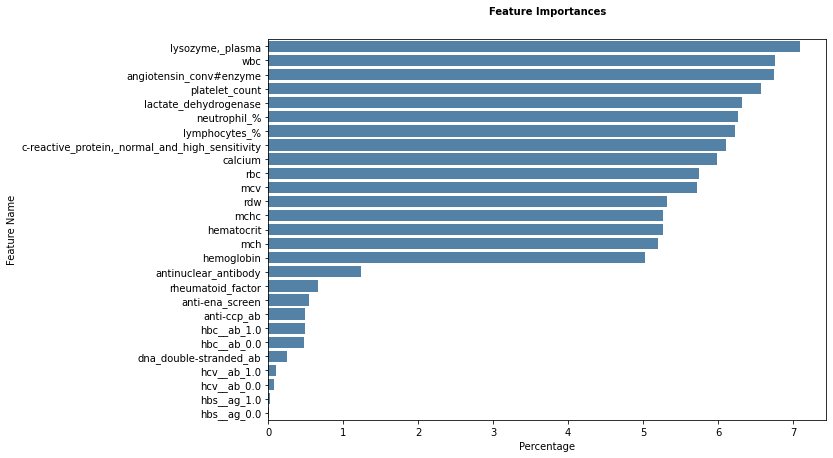

In [16]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

    
ran_tree(X_train, X_test, y_train, y_test)

In [17]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.10753048014077426
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         3
             hla_b27       0.00      0.00      0.00         2
          idiopathic       0.17      0.21      0.19        14
idiopathic_scleritis       0.00      0.00      0.00         5
               other       0.12      0.11      0.12         9
       pars planitis       0.31      0.69      0.43        16
       rheumatologic       0.00      0.00      0.00         1
         sarcoidosis       0.40      0.40      0.40         5
       toxoplasmosis       0.00      0.00      0.00         3
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         4
                 wds       0.20      0.12      0.15         8

            accuracy                           0.25        73
  

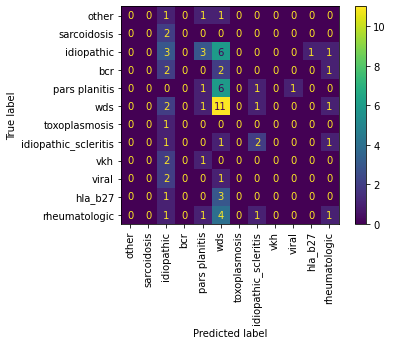

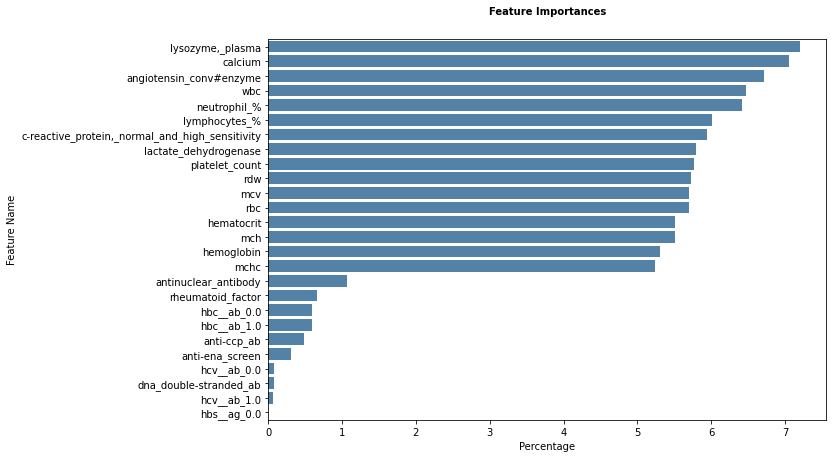

In [18]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.13800426626513582
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 100, 'tree__oob_score': True}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         5
             hla_b27       0.00      0.00      0.00         3
          idiopathic       0.26      0.55      0.35        22
idiopathic_scleritis       0.00      0.00      0.00         9
               other       0.00      0.00      0.00         9
       pars planitis       0.17      0.24      0.20        21
       rheumatologic       1.00      0.50      0.67         4
         sarcoidosis       0.36      0.40      0.38        10
       toxoplasmosis       0.00      0.00      0.00         5
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         7
                 wds       0.06      0.07      0.06        15

            accuracy                           0.21       113
   

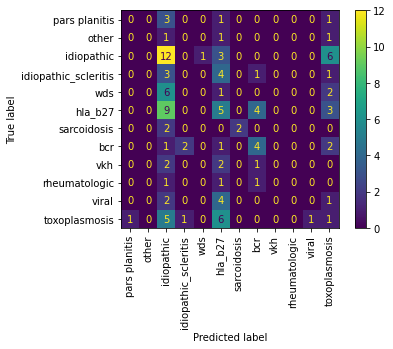

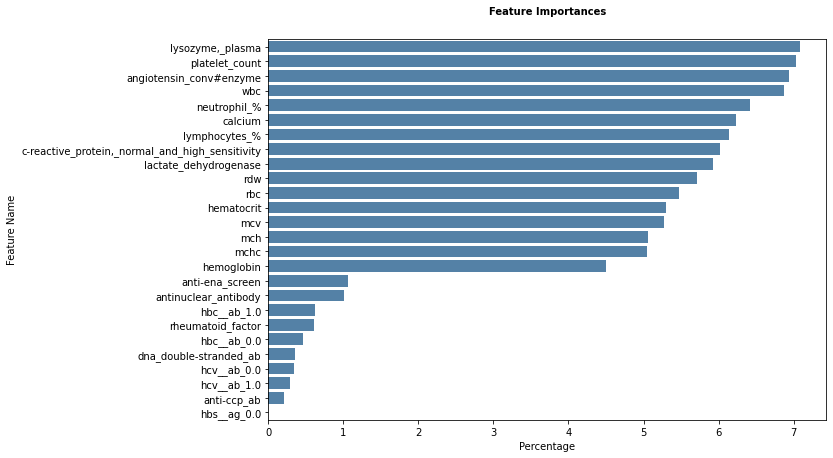

In [19]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.13600136454098777
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
                      precision    recall  f1-score   support

                 bcr       0.11      0.12      0.12         8
             hla_b27       0.00      0.00      0.00         5
          idiopathic       0.29      0.31      0.30        35
idiopathic_scleritis       0.10      0.07      0.08        14
               other       0.00      0.00      0.00        18
       pars planitis       0.21      0.28      0.24        36
       rheumatologic       0.00      0.00      0.00         6
         sarcoidosis       0.43      0.40      0.41        15
       toxoplasmosis       0.00      0.00      0.00         9
               viral       0.00      0.00      0.00         6
                 vkh       0.33      0.27      0.30        11
                 wds       0.18      0.17      0.18        23

            accuracy                           0.19       186
        

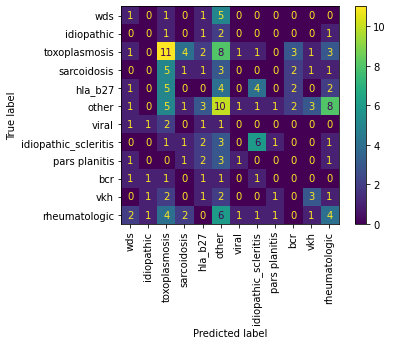

In [20]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.05728549866480901
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         3
             hla_b27       0.00      0.00      0.00         2
          idiopathic       0.13      0.14      0.14        14
idiopathic_scleritis       0.25      0.20      0.22         5
               other       0.00      0.00      0.00         9
       pars planitis       0.23      0.56      0.33        16
       rheumatologic       0.00      0.00      0.00         1
         sarcoidosis       0.00      0.00      0.00         5
       toxoplasmosis       0.00      0.00      0.00         3
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         4
                 wds       0.00      0.00      0.00         8

            accuracy                           0.16        73
       

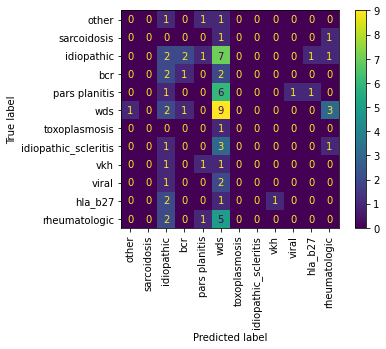

In [21]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.15883944486885662
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
                      precision    recall  f1-score   support

                 bcr       0.17      0.20      0.18         5
             hla_b27       0.00      0.00      0.00         3
          idiopathic       0.26      0.27      0.27        22
idiopathic_scleritis       0.00      0.00      0.00         9
               other       0.00      0.00      0.00         9
       pars planitis       0.25      0.33      0.29        21
       rheumatologic       0.50      0.25      0.33         4
         sarcoidosis       0.29      0.20      0.24        10
       toxoplasmosis       0.33      0.20      0.25         5
               viral       0.00      0.00      0.00         3
                 vkh       0.25      0.14      0.18         7
                 wds       0.15      0.20      0.17        15

            accuracy                           0.19       113
        

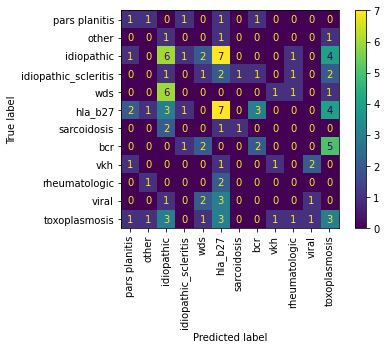

In [22]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.1491844543834935
Best Parameters:
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'linear'}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         8
             hla_b27       0.00      0.00      0.00         5
          idiopathic       0.17      0.06      0.09        35
idiopathic_scleritis       0.50      0.21      0.30        14
               other       0.00      0.00      0.00        18
       pars planitis       0.20      0.17      0.18        36
       rheumatologic       0.50      0.33      0.40         6
         sarcoidosis       0.36      0.53      0.43        15
       toxoplasmosis       0.13      0.44      0.21         9
               viral       0.00      0.00      0.00         6
                 vkh       0.09      0.18      0.12        11
                 wds       0.12      0.04      0.06        23

            accuracy                           0.15      

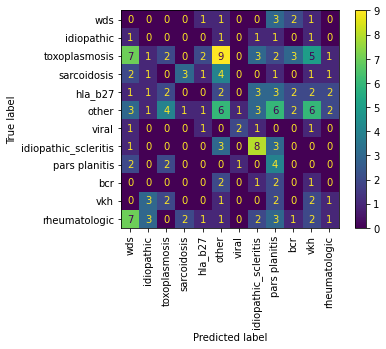

In [23]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.12149657494485079
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                      precision    recall  f1-score   support

                 bcr       0.14      0.33      0.20         3
             hla_b27       0.00      0.00      0.00         2
          idiopathic       0.12      0.07      0.09        14
idiopathic_scleritis       0.14      0.20      0.17         5
               other       0.00      0.00      0.00         9
       pars planitis       0.38      0.31      0.34        16
       rheumatologic       0.00      0.00      0.00         1
         sarcoidosis       0.20      0.40      0.27         5
       toxoplasmosis       0.17      0.33      0.22         3
               viral       0.00      0.00      0.00         3
                 vkh       0.12      0.25      0.17         4
                 wds       0.00      0.00      0.00         8

            accuracy                           0.16        

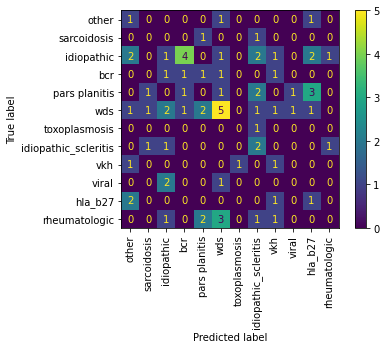

In [24]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.14352343810620144
Best Parameters:
{'svc__C': 1.6, 'svc__class_weight': None, 'svc__degree': 3, 'svc__kernel': 'linear'}
                      precision    recall  f1-score   support

                 bcr       0.25      0.20      0.22         5
             hla_b27       0.00      0.00      0.00         3
          idiopathic       0.24      0.32      0.27        22
idiopathic_scleritis       0.25      0.11      0.15         9
               other       0.00      0.00      0.00         9
       pars planitis       0.18      0.19      0.19        21
       rheumatologic       0.40      0.50      0.44         4
         sarcoidosis       0.27      0.40      0.32        10
       toxoplasmosis       0.00      0.00      0.00         5
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         7
                 wds       0.11      0.13      0.12        15

            accuracy                           0.19       113


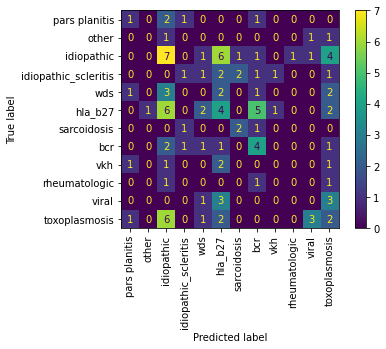

In [25]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.142744584849848
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         8
             hla_b27       0.00      0.00      0.00         5
          idiopathic       0.17      0.29      0.21        35
idiopathic_scleritis       0.62      0.36      0.45        14
               other       0.00      0.00      0.00        18
       pars planitis       0.18      0.33      0.23        36
       rheumatologic       0.22      0.33      0.27         6
         sarcoidosis       0.55      0.40      0.46        15
       toxoplasmosis       0.00      0.00      0.00         9
               viral       0.00      0.00      0.00         6
                 vkh       0.00      0.00      0.00        11
                 wds       0.09      0.09      0.09        23

            accuracy                           0.20       186
           macro avg       0.15      0.15     

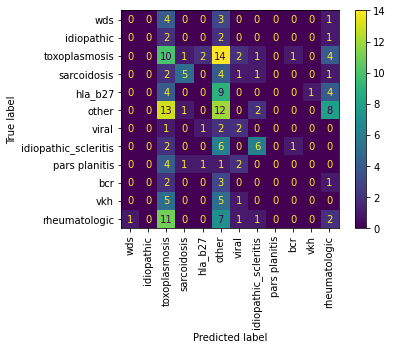

In [27]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.11947387407913723
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         3
             hla_b27       0.00      0.00      0.00         2
          idiopathic       0.14      0.14      0.14        14
idiopathic_scleritis       0.33      0.20      0.25         5
               other       0.20      0.22      0.21         9
       pars planitis       0.25      0.50      0.33        16
       rheumatologic       0.00      0.00      0.00         1
         sarcoidosis       0.33      0.40      0.36         5
       toxoplasmosis       0.00      0.00      0.00         3
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         4
                 wds       0.14      0.12      0.13         8

            accuracy                           0.22        73
           macro avg       0.12      0.13   

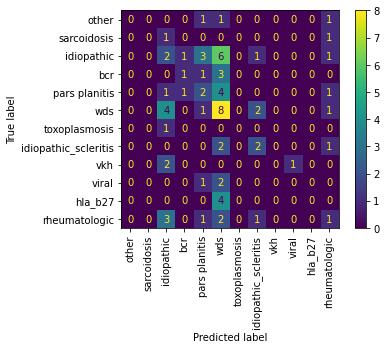

In [28]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.0847917410921023
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                      precision    recall  f1-score   support

                 bcr       0.00      0.00      0.00         5
             hla_b27       0.00      0.00      0.00         3
          idiopathic       0.21      0.36      0.26        22
idiopathic_scleritis       0.00      0.00      0.00         9
               other       0.00      0.00      0.00         9
       pars planitis       0.13      0.24      0.17        21
       rheumatologic       0.33      0.25      0.29         4
         sarcoidosis       0.30      0.30      0.30        10
       toxoplasmosis       0.00      0.00      0.00         5
               viral       0.00      0.00      0.00         3
                 vkh       0.00      0.00      0.00         7
                 wds       0.00      0.00      0.00        15

            accuracy                           0.15       113
           macro avg       0.08      0.10    

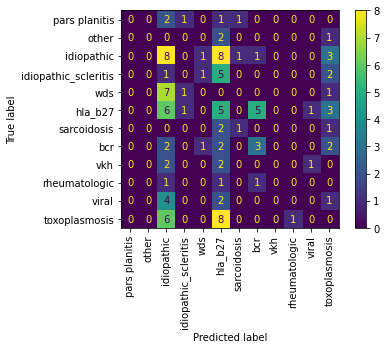

In [29]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

In [30]:
lab = LabelEncoder()
y_train_enc, y_test_enc = lab.fit_transform(y_train), lab.transform(y_test)
y_train_m_enc, y_test_m_enc = lab.fit_transform(y_train_f), lab.transform(y_test_m)
y_train_f_enc, y_test_f_enc = lab.fit_transform(y_train_f), lab.transform(y_test_f)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.16020624566829186
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         5
           2       0.21      0.40      0.28        35
           3       0.29      0.14      0.19        14
           4       0.11      0.06      0.07        18
           5       0.26      0.50      0.35        36
           6       1.00      0.17      0.29         6
           7       0.40      0.27      0.32        15
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         6
          10       0.50      0.18      0.27        11
          11       0.21      0.13      0.16        23

    accuracy                           0.24       186
   macro avg       0.25      0.15      0.16       186
weight

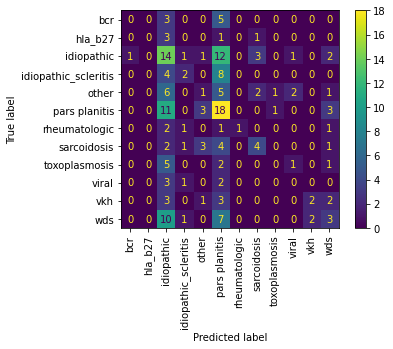

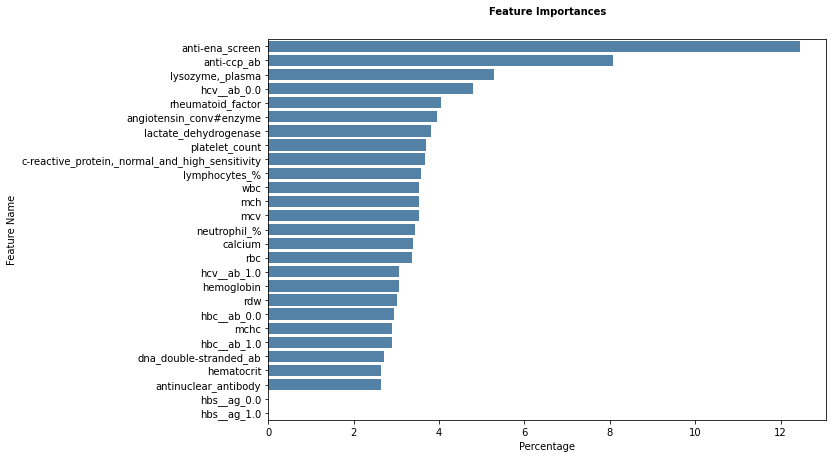

In [31]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0, use_label_encoder=False)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=lab.classes_,
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

    
xgb_all = xgb_model(X_train, X_test, y_train_enc, y_test_enc)

In [32]:
helpers.plot_featureimportance(xgb_all, categorical_features)

TypeError: 'NoneType' object is not subscriptable

### Male positive data

In [ ]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

In [ ]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

In [ ]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

In [ ]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)